In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.io import loadmat
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import time
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
dat = pd.read_csv("/Users/luyue_chen/Documents/Fall2019-proj3-sec1--proj3-sec1-grp7-master/output/feature.csv")
dat = dat.values

In [100]:
class load():
    def load_data(filename):
        raw_data = pd.read_csv(filename)
        raw_data['filename'] = [str(i).zfill(4)+'.jpg' for i in raw_data['Index'].tolist()]
        raw_data['pointsname'] = [str(i).zfill(4)+'.mat' for i in raw_data['Index'].tolist()]
        return raw_data

    #read points data from mat data 
    def load_points(points_path,data):
        n = data.shape[0] 
        points_data = np.zeros([n,3003,2])
        start_time = time.time()
        for i in range(n):
            result = loadmat(points_path+data['pointsname'][i])
            key = sorted(result.keys())[-1] 
            points = result[key]
            distance_h = []
            distance_v = []
            for d in range(points.shape[0]-1):
                for j in range(d+1,points.shape[0]):
                    distance_h.append(abs(points[d,0]-points[j,0]))
                    distance_v.append(abs(points[d,1]-points[j,1]))

            points_data[i,:,0]=distance_h
            points_data[i,:,1]=distance_v
        print("--- %s seconds ---" % (time.time() - start_time))
        return points_data.reshape(2500,6006)

In [108]:
path = '/Users/luyue_chen/Documents/Fall2019-proj3-sec1--proj3-sec1-grp7-master/data/train_set/'
data = load.load_data(path+'label.csv')
points_path = '/Users/luyue_chen/Documents/Fall2019-proj3-sec1--proj3-sec1-grp7-master/data/train_set/points/'
X = load.load_points(points_path,data)
y = data['emotion_idx']
train_x,test_x,train_y,test_y=train_test_split(X,y,test_size=0.2,random_state=123)

--- 17.46095108985901 seconds ---


## SVM

In [112]:
print("Fitting the classifier to the training set")
t0 = time.time()
svm = SVC( C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=0.005, kernel='poly',
          max_iter=-1,probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(train_x, train_y)
print("done in %0.3fs" % (time.time() - t0))

Fitting the classifier to the training set
done in 24.108s


In [113]:
print("Using the trained model to test test set")
t0 = time.time()
pred= svm.predict(test_x)
print("done in %0.3fs" % (time.time() - t0))
print("Accuracy Rate:")
np.mean(pred==test_y)

Using the trained model to test test set
done in 6.342s
Accuracy Rate:


0.454

In [117]:
print("Fitting the classifier to the whole data set")
t0 = time.time()
svm_final = SVC( C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=0.005, kernel='poly',
          max_iter=-1,probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X, y)
print("--- %s seconds ---" % (time.time() - t0))

Fitting the classifier to the whole data set
--- 34.8629367351532 seconds ---


In [119]:
joblib.dump(svm_final,'svm.m')

['svm.m']

### Confusion Matrix

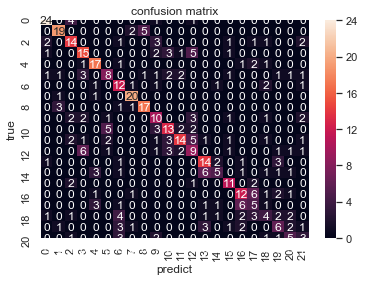

In [56]:
sns.set()
f,ax=plt.subplots()
cm = confusion_matrix(test_y,pred, labels=np.arange(22)+1)
sns.heatmap(cm,annot=True,ax=ax)
ax.set_title('confusion matrix') 
ax.set_xlabel('predict') 
ax.set_ylabel('true')
plt.savefig('cm_svm.png')

In [ ]:
print(classification_report(test_y,pred))

### 5 Folds Cross-Validation

In [11]:
X=dat[:,1:6007]
y=dat[:,6007]
err=[]
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    svm1=SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=0.005, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)
    pred1=svm1.predict(X_test)
    err.append(np.mean(pred1!=y_test))

In [46]:
err

[0.522, 0.526, 0.508, 0.532, 0.506]

## XGBoost

In [121]:
print("Fitting the classifier to the training set")
t0 = time.time()
xgbt = xgb.XGBClassifier(objective ='multi:softmax', colsample_bytree = 0.8, sub_sample=0.8, learning_rate = 0.01,
                max_depth = 6, alpha = 10, n_estimators = 200, min_child_weight = 6)
xgbt.fit(train_x,train_y)
print("done in %0.3fs" % (time.time() - t0))

Fitting the classifier to the training set


KeyboardInterrupt: 

In [ ]:
print("Using the trained model to test test set")
t0 = time()
xgbt_pred = xgbt.predict(test_x)
print("done in %0.3fs" % (time() - t0))
print("Accuracy Rate:")
np.mean(pred==test_y)
np.mean(xgbt_pred==test_y)

In [ ]:
xgbt_final = xgb.XGBClassifier(objective ='multi:softmax', colsample_bytree = 0.8, sub_sample=0.8, learning_rate = 0.01,
                max_depth = 6, alpha = 10, n_estimators = 200, min_child_weight = 6).fit(X,y)

In [ ]:
joblib.dump(xgbt_final,'xgbt.m')

### Confusion Matrix

In [ ]:
import seaborn as sns
sns.set()
f,ax=plt.subplots()
cm = confusion_matrix(test_y,xgbt_pred, labels=np.arange(22)+1)
sns.heatmap(cm,annot=True,ax=ax)
ax.set_title('confusion matrix') 
ax.set_xlabel('predict') 
ax.set_ylabel('true')
plt.savefig('cm_xgbt.png')

In [ ]:
print(classification_report(test_y,xgbt_pred))

### 5 Folds Cross-Validation

In [48]:
X=dat[:,1:6007]
y=dat[:,6007]
xgbt_err=[]
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    xgbt1 = xgb.XGBClassifier(objective ='multi:softmax', colsample_bytree = 0.8, sub_sample=0.8, learning_rate = 0.01,
                max_depth = 6, alpha = 10, n_estimators = 200).fit(X_train, y_train)
    xgbt_pred1=xgbt1.predict(X_test)
    xgbt_err.append(np.mean(xgbt_pred1!=y_test))

KeyboardInterrupt: 

In [ ]:
xgbt_err